# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами.

## Шаг 1. Загрузите данные

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import mannwhitneyu
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [2]:
#pip install -U seaborn

In [3]:
data = pd.read_csv('/1/gym_churn.csv')

## Шаг 2. Проведите исследовательский анализ данных (EDA)

In [4]:
def basic_info(data):
    data.columns = data.columns.str.lower()
    print ('\033[1m' + 'Вывод метода info()' + '\033[0m')
    print(data.info())
    print ('\033[1m' + 'Вывод метода describe()' + '\033[0m')
    display(data.describe())
    print ('\033[1m' + 'Дубликаты' + '\033[0m')
    display(data.duplicated().sum())
    display(data.head(10))
    print ('\033[1m' + 'Пропуски в таблице' + '\033[0m')
    display(pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm'))
    
basic_info(data)

Вывод метода info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Дубликаты


0

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Пропуски в таблице


,0
gender,0.000000
near_location,0.000000
partner,0.000000
promo_friends,0.000000
phone,0.000000
contract_period,0.000000
group_visits,0.000000
age,0.000000
avg_additional_charges_total,0.000000
month_to_end_contract,0.000000


#### Выводы:
- Данные достаточно репрезентативны;
- Категориальных переменных нет;
- Пропусков и дубликатов нет.

### Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [5]:
data_mean = data.groupby('churn', as_index = False).mean().T
data_mean = data_mean.drop('churn').rename(columns={0: 'data_mean_active', 1: 'data_mean_passive'})
data_mean

,data_mean_active,data_mean_passive
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


In [6]:
data_std = data.groupby('churn', as_index = False).std().T
data_std = data_std.drop('churn').rename(columns={0: 'data_std_active', 1: 'data_std_passive'})
data_std

,data_std_active,data_std_passive
gender,0.499984,0.500118
near_location,0.332933,0.422217
partner,0.498914,0.478837
promo_friends,0.478144,0.387495
phone,0.295040,0.296204
contract_period,4.716942,2.132371
group_visits,0.498795,0.443448
age,3.009933,2.895163
avg_additional_charges_total,99.801599,77.696419
month_to_end_contract,4.363522,1.964593


#### Выводы:
- У переменных довольно разные по величине стандартные отклонения, а значит их нужно будет стандартизировать перед обучением;
- В среднем люди, которых привели друзья, остаются дольше;
- Те, кому до фитнессцентра дольше добираться, чаще перестают ходить;

### Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался

In [7]:
data_mean_drop = data_mean.drop(data[['avg_additional_charges_total', 'age']])
data_std_drop = data_std.drop(data[['avg_additional_charges_total']])

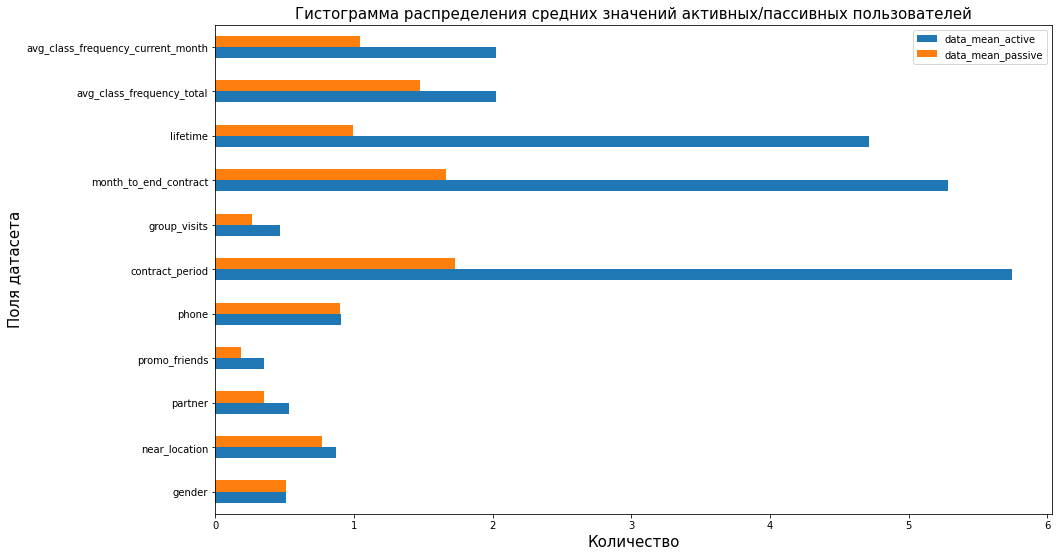

In [8]:
data_mean_drop[['data_mean_active', 'data_mean_passive']].plot(
    kind='barh', figsize=(15,9))
plt.title('Гистограмма распределения средних значений активных/пассивных пользователей', fontsize = 15);
plt.ylabel('Поля датасета',fontsize = 15);
plt.xlabel('Количество', fontsize = 15)
plt.show()

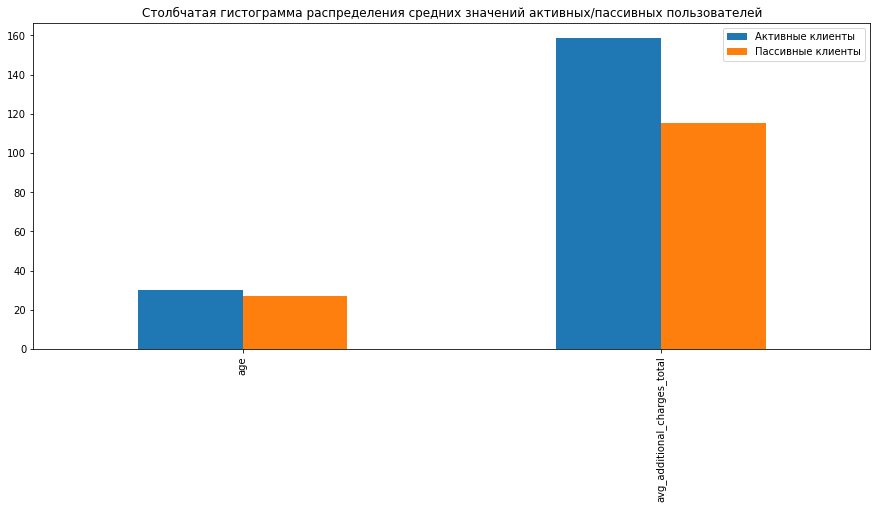

In [9]:
(data_mean.loc[
    ['age', 'avg_additional_charges_total'],
    ['data_mean_active', 'data_mean_passive']
].rename(columns={'data_mean_active': 'Активные клиенты', 'data_mean_passive': 'Пассивные клиенты'})).plot(
    kind='bar', figsize=(15,6),
    title='Столбчатая гистограмма распределения средних значений активных/пассивных пользователей'
)

plt.show()

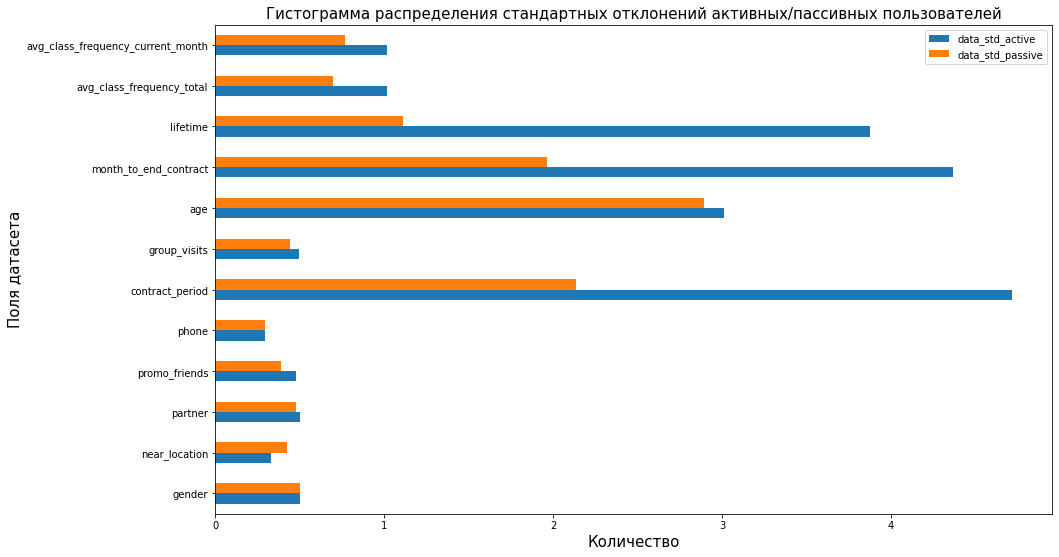

In [10]:
data_std_drop[['data_std_active', 'data_std_passive']].plot(
    kind='barh', figsize=(15,9))
plt.title('Гистограмма распределения стандартных отклонений активных/пассивных пользователей', fontsize = 15);
plt.ylabel('Поля датасета',fontsize = 15);
plt.xlabel('Количество', fontsize = 15)
plt.show()

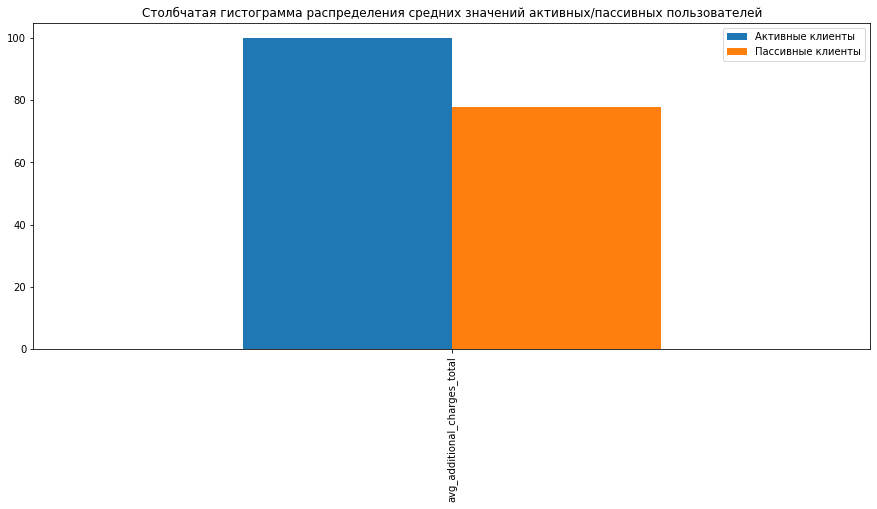

In [11]:
(data_std.loc[
    ['avg_additional_charges_total'],
    ['data_std_active', 'data_std_passive']
].rename(columns={'data_std_active': 'Активные клиенты', 'data_std_passive': 'Пассивные клиенты'})).plot(
    kind='bar', figsize=(15,6),
    title='Столбчатая гистограмма распределения средних значений активных/пассивных пользователей'
)

plt.show()

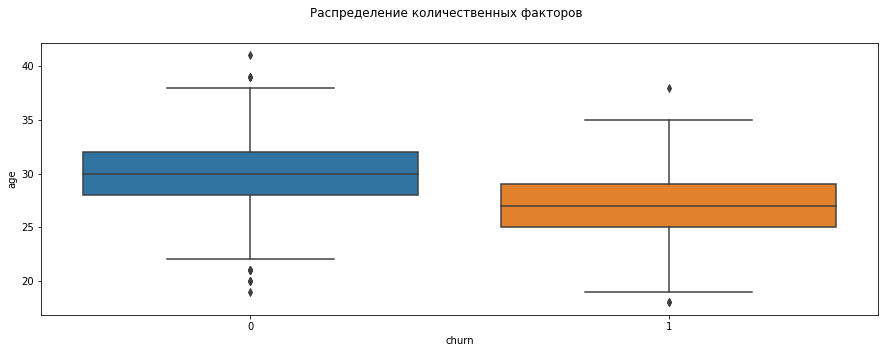

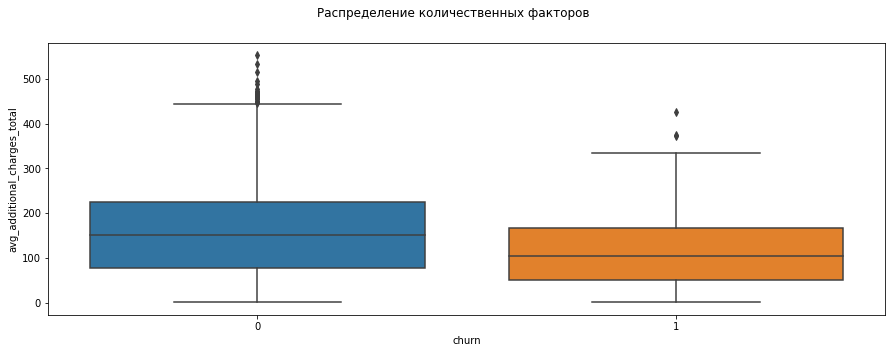

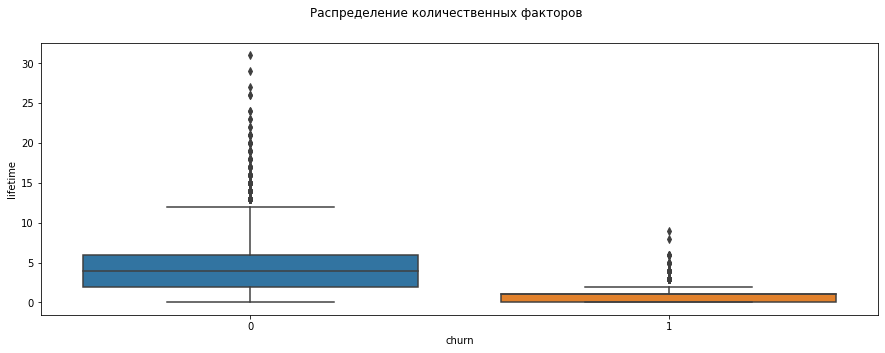

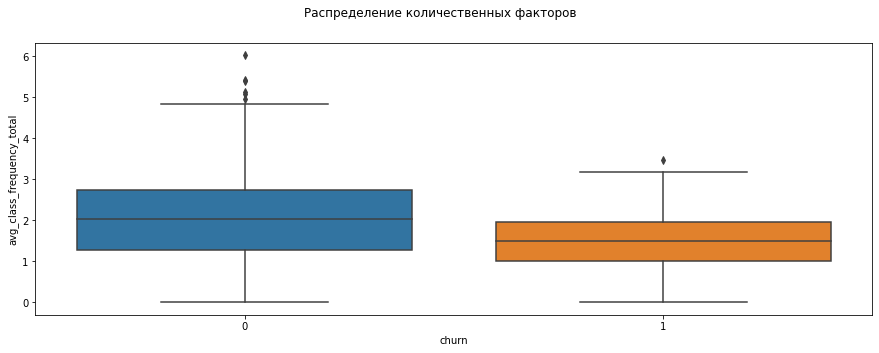

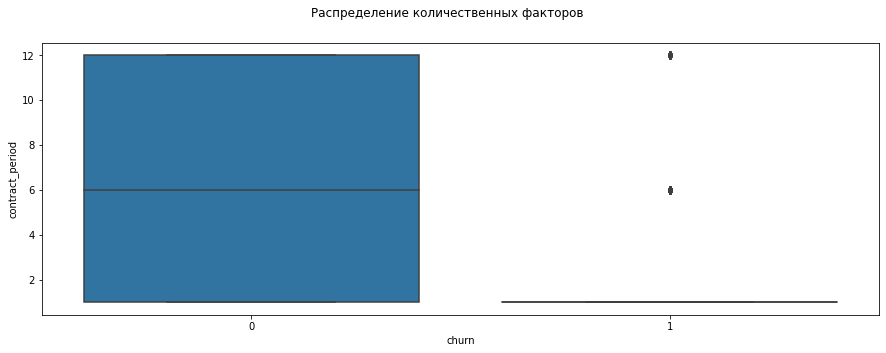

In [12]:
columns = ['age','avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'contract_period']

for i in columns:
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=data, x='churn', y=i)
    plt.suptitle('Распределение количественных факторов')
    plt.show()

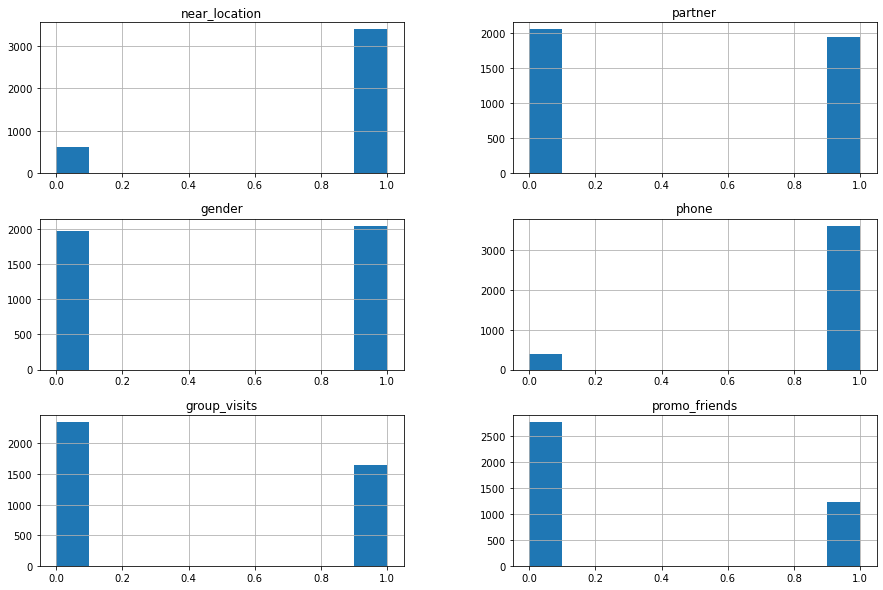

In [13]:
features = list(set(['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']))

data[features].hist(figsize=(15,10));

#### Выводы:
- На графиках можно наглядно убедиться в различиях средних значений и стандартных отклонений между двумя выборками.

### Постройте матрицу корреляций и отобразите её.

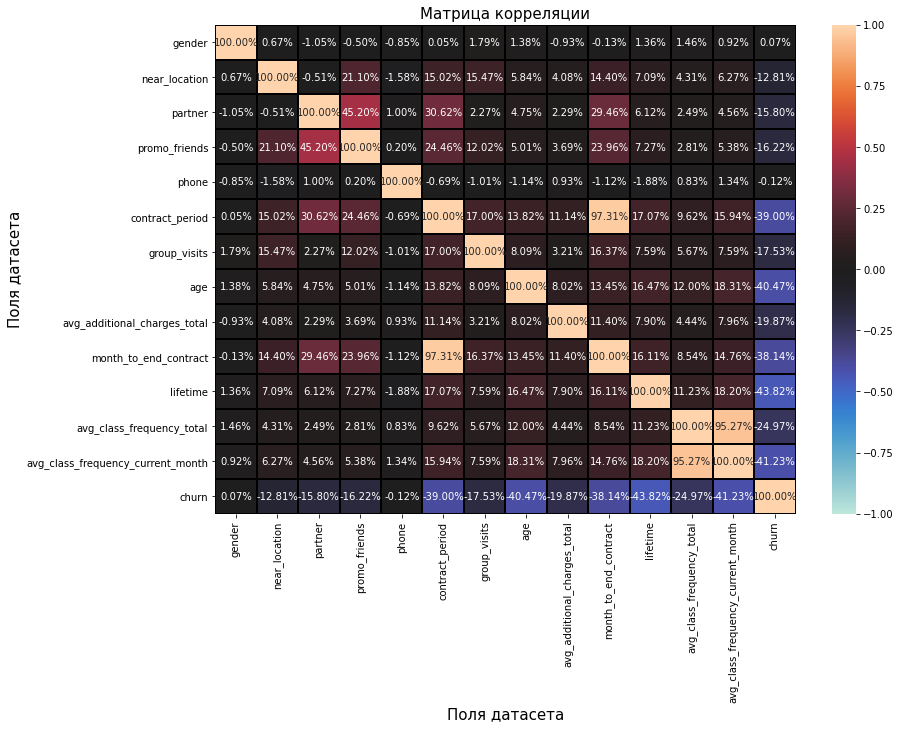

In [14]:
# Создадим тепловую карту
cm = data.corr()  
plt.figure(figsize=(13, 9))
plt.title('Матрица корреляции', fontsize = 15)
sns.heatmap(cm, annot=True, fmt='.2%', linewidths=1, linecolor='black', 
             xticklabels= cm.columns, yticklabels= cm.index,
             vmin=-1, vmax=1, center= 0)
plt.xlabel('Поля датасета', fontsize = 15);
plt.ylabel('Поля датасета', fontsize = 15);
plt.show()

#### Выводы:
В данных есть пары мультиколлинеарных признаков:
- contract_period и Month_to_end_contract;
- Avg_class_frequency_current_month и Avg_additional_charges_total.

Удалим одну из таких переменных перед обуением.

### Общие выводы:
- Данные достаточно репрезентативны;
- Категориальных переменных нет;
- Пропусков и дубликатов нет;
- У переменных довольно разные по величине стандартные отклонения, а значит их нужно будет стандартизировать перед обучением;
- В среднем люди, которых привели друзья, остаются дольше;
- Те, кому до фитнессцентра дольше добираться, чаще перестают ходить;
- На графиках видны различия средних значений и стандартных отклонений между двумя выборками;
- В данных есть пары мультиколлинеарных признаков, которые нужно удалить.

## Шаг 3. Постройте модель прогнозирования оттока клиентов

In [15]:
# Удаляем мультиколлинеарные признаки
data = data.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1)

In [16]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns=['churn'])
y = data['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)


# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

# задайте список моделей
models = [
    LogisticRegression(random_state = 0),
    RandomForestClassifier(random_state = 0),
]

# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'accuracy_score:{:.2f} precision_score:{:.2f} recall_score:{:.2f} '.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
        )
    )

# напишите цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(
        m=i,
        X_train=X_train_st,
        y_train=y_train,
        X_test=X_test_st,
        y_test=y_test,
    )    

LogisticRegression(random_state=0)
accuracy_score:0.90 precision_score:0.79 recall_score:0.81 
RandomForestClassifier(random_state=0)
accuracy_score:0.89 precision_score:0.79 recall_score:0.76 


### Вывод:
- Все метрики лучше у метода LogisticRegression.

## Шаг 4. Сделайте кластеризацию клиентов

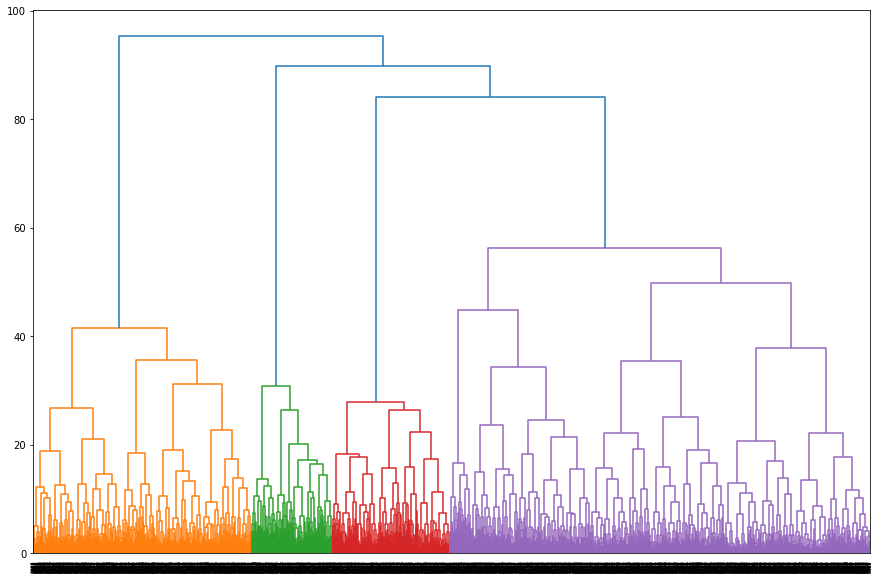

In [17]:
# Стандартизируйте данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

#### Промежуточный вывод:
- Всего 4 кластера.

In [18]:
# задаём модель k_means с числом кластеров 5, потому что того требует условие задания
km = KMeans(n_clusters=5, random_state = 0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)
# сохраняем метки кластера в поле датасета
data['cluster'] = labels

In [19]:
# выводим статистику по средним значениям признаков по кластеру
data.groupby(['cluster']).mean().T

cluster,0,1,2,3,4
gender,0.502683,0.486867,0.561614,0.488806,0.523316
near_location,0.000000,0.996248,0.996728,1.000000,0.862694
partner,0.490161,0.943715,0.267176,0.223881,0.471503
promo_friends,0.078712,0.883677,0.050164,0.078358,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.000000,7.660413,5.241003,2.082090,4.777202
group_visits,0.232558,0.523452,0.533261,0.286381,0.427461
age,28.708408,29.474672,30.958561,27.584888,29.297927
avg_additional_charges_total,137.385192,149.409166,186.697490,116.455656,144.208179
lifetime,3.007156,4.057223,5.778626,1.933769,3.940415


#### Промежуточный вывод:
- Все кластеры различаются по силе оттока. Самые лучшие показатели у 1 кластера - всего 12% ушедших. Хуже всего дела обстоят у кластеров 0 и 2 (около 40%);
- В кластерах 0 и 2 люди реже ходили на групповые занятия и вообще реже посещали тренировки, также люди в них немного моложе;
- В кластере 0 люди очень далеко живут от спортзала;
- Кластер 4 был, видимо, сформирован из людей, которые не оставляли свой телефон;
- В кластерах 0, 2 и 3 люди в основном приходили не по по советам друзей.

## Шаг 5. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами

### Общие выводы:
- Данные достаточно репрезентативны;
- Категориальных переменных нет;
- Пропусков и дубликатов нет;
- У переменных довольно разные по величине стандартные отклонения, а значит их нужно будет стандартизировать перед обучением;
- В среднем люди, которых привели друзья, остаются дольше;
- Те, кому до фитнессцентра дольше добираться, чаще перестают ходить;
- На графиках видны различия средних значений и стандартных отклонений между двумя выборками;
- В данных есть пары мультиколлинеарных признаков, которые нужно удалить.


- Все метрики лучше у метода LogisticRegression.


- Все кластеры различаются по силе оттока. Самые лучшие показатели у 1 кластера - всего 12% ушедших. Хуже всего дела обстоят у кластеров 0 и 2 (около 40%);
- В кластерах 0 и 2 люди реже ходили на групповые занятия и вообще реже посещали тренировки, также люди в них немного моложе;
- В кластере 0 люди очень далеко живут от спортзала;
- Кластер 4 был, видимо, сформирован из людей, которые не оставляли свой телефон;
- В кластерах 0, 2 и 3 люди в основном приходили не по по советам друзей.

### Рекомендации:
- Следует советовать новым клиентам групповые занятия;
- Следует советовать новым клиентам ходить в зал не реже 2-х раз в неделю;
- Людям, которые живут далеко от спротзала, стоит продавать абонементы дороже, возможно так им будет обиднее пропускать занятия и они будут заставлять себя приходить;
- Сделать упор в рекламе на основе данных по людям из кластера 0.

Шаг 1. Загрузите данные

Шаг 2. Проведите исследовательский анализ данных (EDA)
- [x] Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения (пригодится метод describe());
- [x] Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby());
- [x] Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
- [x] Постройте матрицу корреляций и отобразите её.

Шаг 3. Постройте модель прогнозирования оттока клиентов
- [x] Постройте модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:
- [x] Разбейте данные на обучающую и валидационную выборку функцией train_test_split().
- [x] Обучите модель на train-выборке двумя способами: логистической регрессией и случайным лесом.
- [x] Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель показала себя лучше на основании метрик?

Шаг 4. Сделайте кластеризацию клиентов
- [x] Отложите в сторону столбец с оттоком и проведите кластеризацию объектов (клиентов):
- [x] Стандартизируйте данные.
- [x] Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.
- [x] Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).
- [x] Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
- [x] Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?
- [x] Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

Шаг 5. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами
- [x] Сформулируйте основные выводы и предложите рекомендации для стратегии взаимодействия с клиентами и их удержания.
- [x] Не описывайте стратегию детально: достаточно 3-4 важных принципов и примеров их реализации в виде определённых маркетинговых действий.